## new testing section for the notebook


## Testing to use the message from 3 commas to start and stop the trading bot

In [2]:
import requests

# Define the API endpoint
api_url = "https://3commas.io/trade_signal/trading_view"

# Your data payload this is for stopping the bot
payload = {
    "action": "stop_bot",
    "message_type": "bot",
    "bot_id": 11767904,
    "email_token": "910eaf15-60fd-4e5b-ac35-a22125a38efe",
    "delay_seconds": 0
}

# # Your data payload this is for starting the bot
# payload = {
#     "action": "start_bot",  
#     "message_type": "bot",  
#     "bot_id": 11767904,  
#     "email_token": "910eaf15-60fd-4e5b-ac35-a22125a38efe",  
#     "delay_seconds": 0
# }

# Send POST request
response = requests.post(api_url, json=payload)

# Check response
if response.status_code == 200:
    print("Bot stopped successfully.")
else:
    print("Failed to stop the bot. Status code:", response.status_code)

Bot stopped successfully.


In [9]:
#
# todo convert a string dict to a dictionary

str_dict = '''{
    "action": "start_bot",  
    "message_type": "bot",  
    "bot_id": 11767904,  
    "email_token": "910eaf15-60fd-4e5b-ac35-a22125a38efe",  
    "delay_seconds": 0 
}'''

print(type(str_dict))

# Convert string dict to dict
trade_dict = eval(str_dict)
print(type(trade_dict))
import json
trade_dict = json.dumps(trade_dict, indent=4)
print(trade_dict)


<class 'str'>
<class 'dict'>
{
    "action": "start_bot",
    "message_type": "bot",
    "bot_id": 11767904,
    "email_token": "910eaf15-60fd-4e5b-ac35-a22125a38efe",
    "delay_seconds": 0
}


In [1]:
import yfinance as yf

# Get the data for CAD=X
ticker = yf.Ticker('ETH-USD')
data = ticker.history(period='3mo', interval='1d')

# drop the columns that are not needed
data.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1, inplace=True)

data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 92 entries, 2023-09-10 00:00:00+00:00 to 2023-12-10 00:00:00+00:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    92 non-null     float64
 1   High    92 non-null     float64
 2   Low     92 non-null     float64
 3   Close   92 non-null     float64
dtypes: float64(4)
memory usage: 3.6 KB


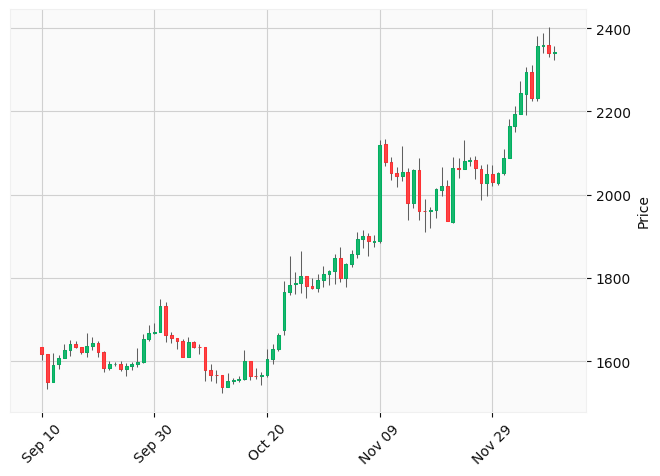

In [2]:
import mplfinance as mpf

mpf.plot(data, type='candle', style='yahoo')  # differmt styles are avalible




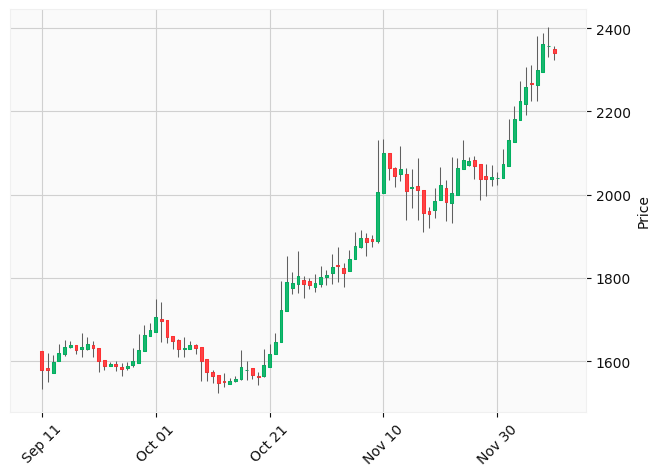

In [3]:
# Create a new dataframe and calulate the hieken ashi 
ha_data = data.copy()
ha_data['HA_Close'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4

idx = ha_data.index.name
ha_data.reset_index(inplace=True)

ha_data['HA_Open'] = (ha_data['Open'].shift(1) + ha_data['Close'].shift(1)) / 2
ha_data['HA_High'] = ha_data[['High', 'HA_Open', 'HA_Close']].max(axis=1)
ha_data['HA_Low'] = ha_data[['Low', 'HA_Open', 'HA_Close']].min(axis=1)

if idx:
    ha_data.set_index(idx, inplace=True)
ha_data.dropna(inplace=True)

# drop the Open High Low Close columns and rename the HA_ columns and plot
ha_data.drop(['Open', 'High', 'Low', 'Close'], axis=1, inplace=True)
ha_data.rename(columns={'HA_Open': 'Open', 'HA_High': 'High', 'HA_Low': 'Low', 'HA_Close': 'Close'}, inplace=True)

mpf.plot(ha_data, type='candle', style='yahoo')  # differmt styles are avalible

In [4]:
# use plotly to plot the data
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=ha_data.index,
                open=ha_data['Open'],
                high=ha_data['High'],
                low=ha_data['Low'],
                close=ha_data['Close'])])

# drop the slider
fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

# Dividend chart showing upcoming opportunities

In [3]:
import requests
import datetime
import pandas as pd
import plotly.express as px


# set api key
API_KEY = 'I3RTEm6vso7yOXBhGcYSidwUhRHaSgWy'
# Get today's date
today = datetime.date.today()
# Calculate tomorrow's date
tomorrow = today + datetime.timedelta(days=1)
# Calculate the end of the current month
end_of_month = today.replace(day=28) + datetime.timedelta(days=4)

# Define the API endpoint with parameters for the date range
api_url = f"https://api.polygon.io/v3/reference/dividends?ex_dividend_date.gt={tomorrow}&ex_dividend_date.lt={end_of_month}&limit=1000&apiKey={API_KEY}"

# Send GET request to the API
response = requests.get(api_url)
# Convert the response to JSON
data = response.json()

# Create a DataFrame from the API response
df = pd.DataFrame(data['results'])
# Sort DataFrame by the ex-dividend date
df.sort_values(by=['ex_dividend_date'], inplace=True)

# Group by ex_dividend_date and count the number of stocks for each date
stocks_per_date = df.groupby(['ex_dividend_date']).size()

# Get the current month's name for the plot title
current_month = datetime.datetime.now().strftime("%B")

# Create a bar plot with the grouped data
fig = px.bar(stocks_per_date, title=f'Upcoming Ex-Dividends for {current_month}')
# Update plot labels
fig.update_layout(xaxis_title='Ex-Dividend Date', yaxis_title='Number of Stocks', showlegend=False)
# Customize hover data
fig.update_traces(hovertemplate='Ex-Dividend Date: %{x}<br>Number of Stocks: %{y}')

# Display the plot
fig.show()
